# Approximating Lévy Stable log density

In [1]:
import math
import numpy as np
from scipy.stats import levy_stable
import scipy.special
import pyro.distributions as dist
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.linewidth'] = 0.1
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levy_stable.html
# levy_stable.parameterization = "S0"

## Building intuition

In [2]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))
def logit(x):
    return np.log(x) - np.log1p(-x)

def _():
    x = np.linspace(-10, 10, 100)
    assert np.allclose(x, logit(sigmoid(x)))
_()

In [3]:
def S0_to_S1(a, b, x):
    assert isinstance(a, (int, float))
    return x if a == 1 else x + b * np.tan(np.pi / 2 * a)

def S1_to_S0(a, b, z):
    assert isinstance(a, (int, float))
    return z if a == 1 else z - b * np.tan(np.pi / 2 * a)

In [4]:
a_grid = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
b_grid = [0.0, 0.2, 0.5, 0.8, 0.9, 1.0]
x_grid = [-10.0, -1.0, -0.1, 0.0, 0.1, 1.0, 10.0]

Let's build up some intuition by visualizing the density on a transformed real line `x = atanh(reals)`.

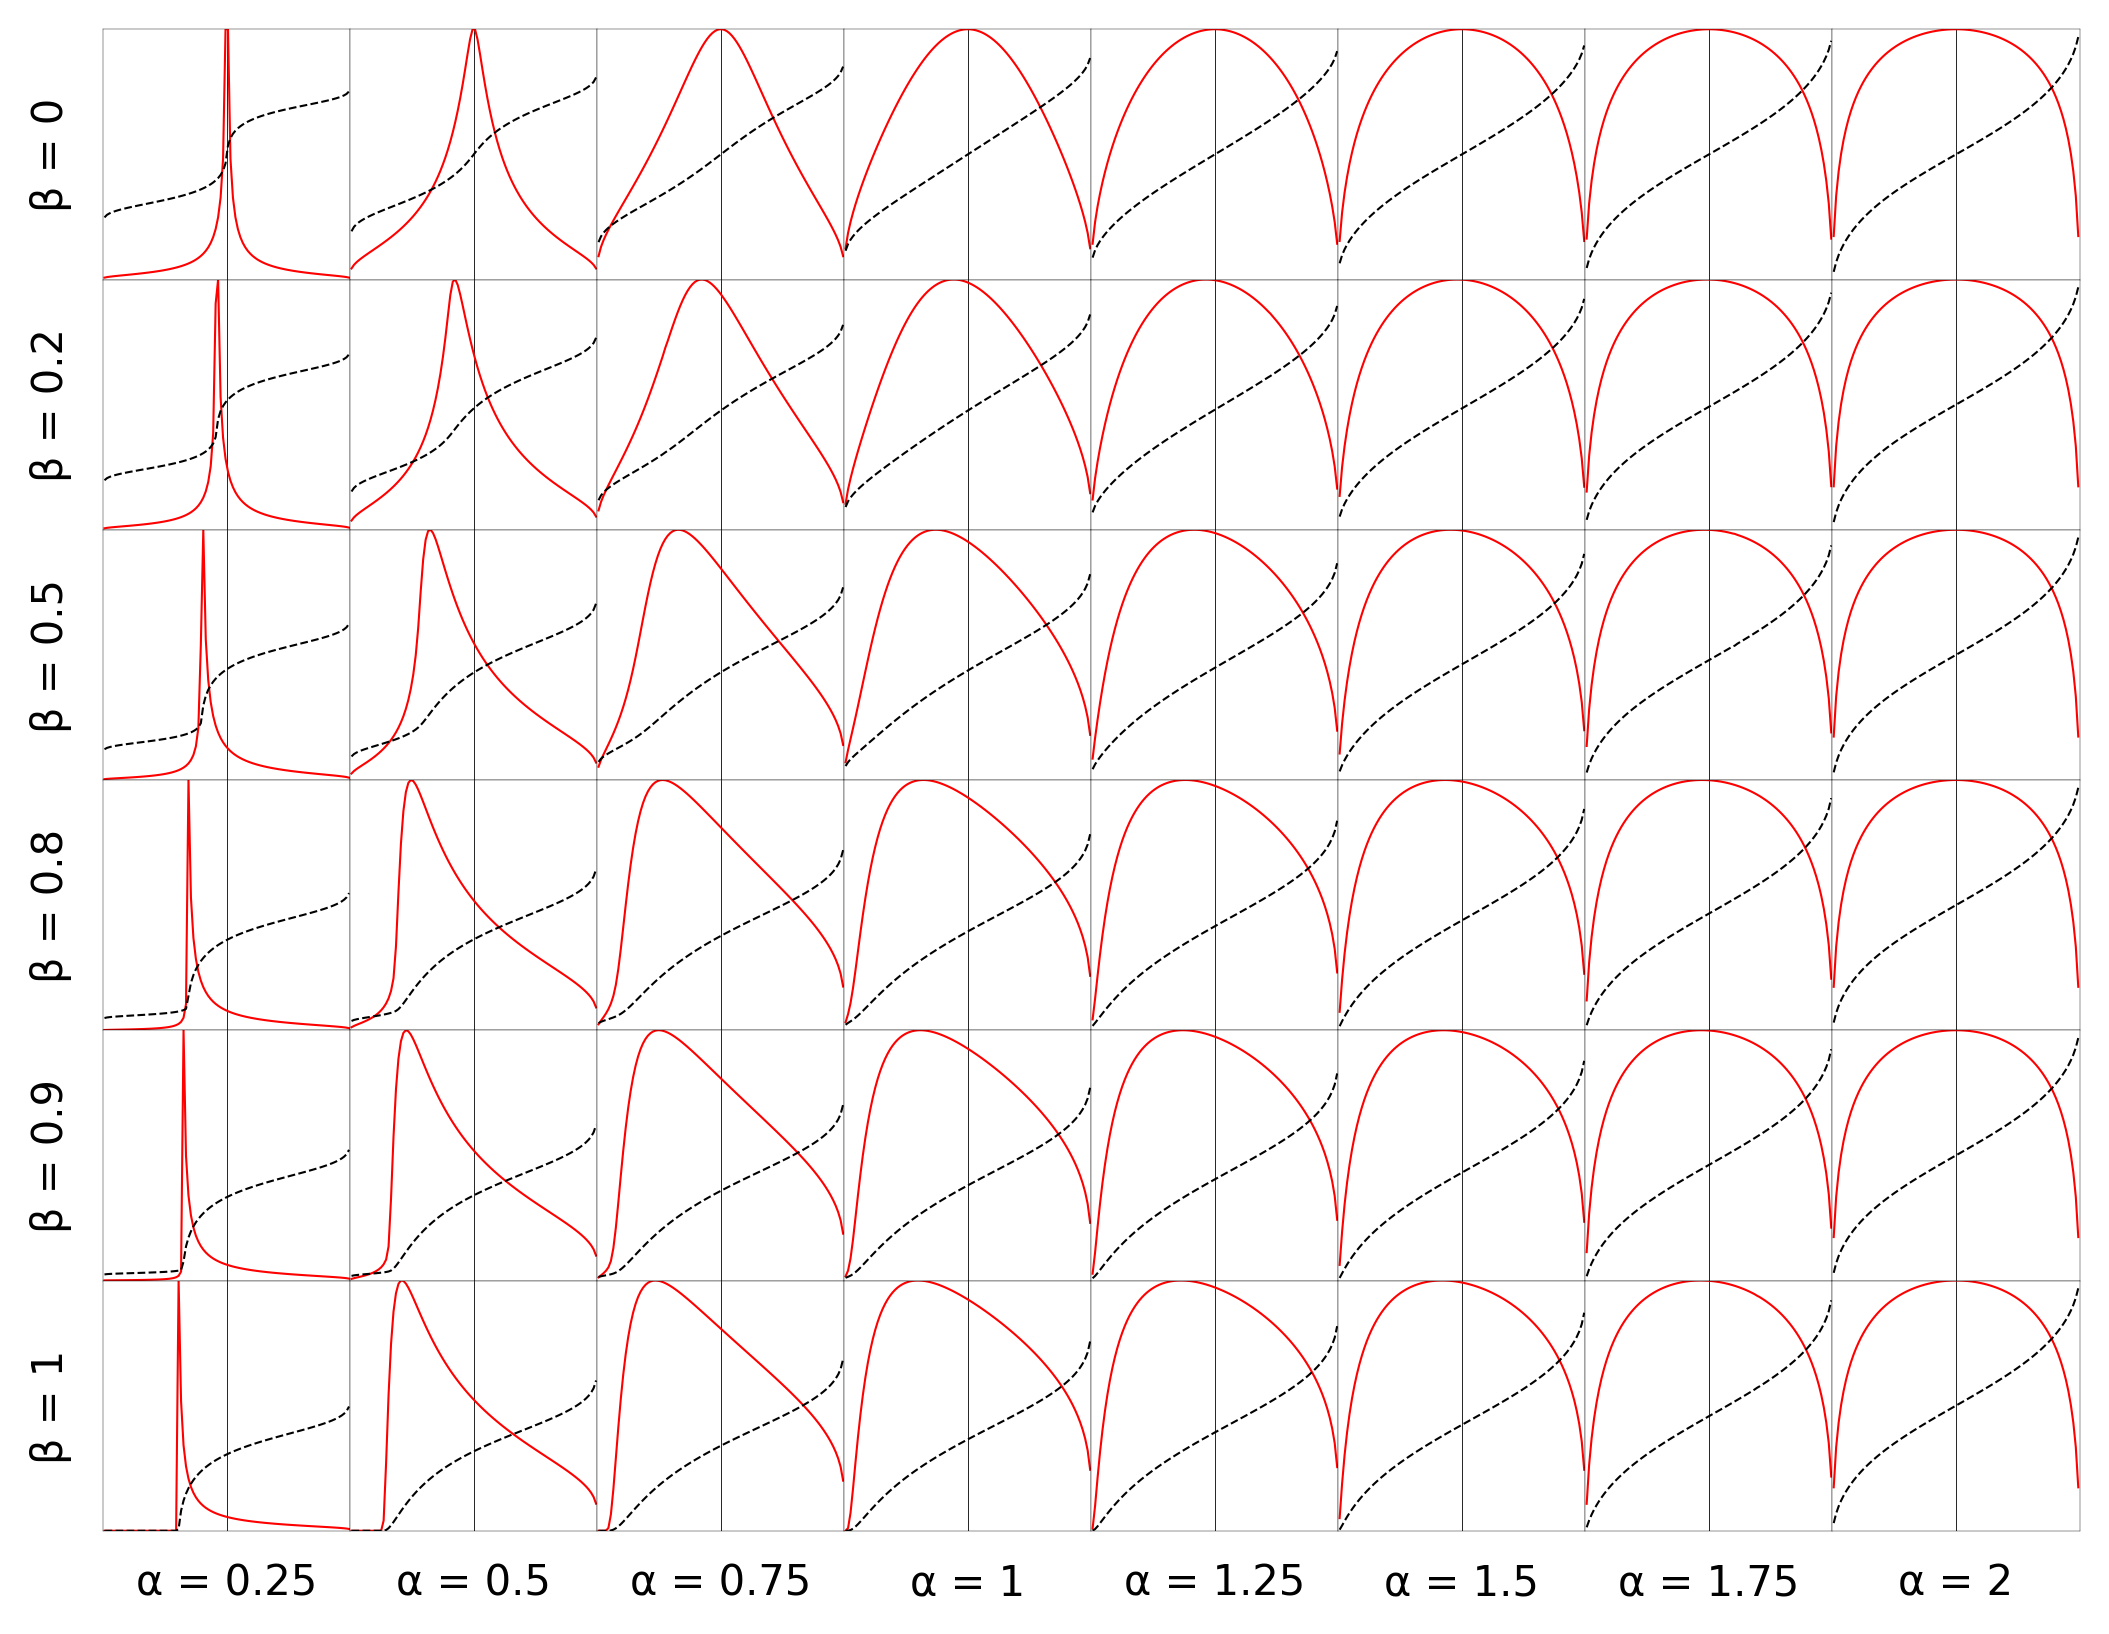

In [5]:
def plot_density(n=100):
    u = np.linspace(1/n - 1, 1 - 1/n, n)
    x = np.arctanh(u)
    fig, axes = plt.subplots(
        len(b_grid), len(a_grid), sharex=True, sharey=True,
        figsize=(0.5 + len(a_grid), 0.5 + len(b_grid)), dpi=300)
    for i, b in enumerate(b_grid):
        for j, a in enumerate(a_grid):
            ax = axes[i][j]
            ax.axvline(0, lw=0.2, color="k")
            # Convert from S0 to Scipy's S1 coordinates.
            # Note that scipy.stasts.levy_stable.parameterization
            # appears not to be configurable from the default S1.
            z = S0_to_S1(a, b, x)
            p = levy_stable(a, b).pdf(z)
            p /= p.max()
            ax.plot(u, p, "r-", lw=0.5)
            c = levy_stable(a, b).cdf(z)
            ax.plot(u, c, "k--", lw=0.5)
            ax.set_xlim(-1, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks(())
            ax.set_yticks(())
            if i == len(b_grid) - 1:
                ax.set_xlabel(f"α = {a:0.3g}")
            if j == 0:
                ax.set_ylabel(f"β = {b:0.3g}")
    plt.subplots_adjust(hspace=0, wspace=0)
plot_density()

In [6]:
def plot_hist(a, b, n=100, num_samples=10000, bins=31):
    # True density.
    u = np.linspace(1/n - 1, 1 - 1/n, n)
    x = np.arctanh(u)
    z = S0_to_S1(a, b, x)
    plt.axvline(0, lw=0.2, color="k")
    p = levy_stable(a, b).pdf(z) / (1 - u**2)
    # p /= p.max()
    plt.plot(u, p, "r-", lw=0.5)
    
    # Empirical density.
    x = dist.Stable(a, b).sample([num_samples]).numpy()
    u = np.tanh(x)
    plt.hist(u, bins=np.linspace(-1.0, 1.0, bins), density=True)
    
    # Empirical density.
    z = levy_stable(a, b).rvs(num_samples)
    x = S1_to_S0(a, b, z)
    u = np.tanh(x)
    plt.hist(u, color="red", alpha=0.5, bins=np.linspace(-1.0, 1.0, bins), density=True)
    
    plt.xlim(-1, 1)
    plt.ylim(0, 1)
    plt.xticks(())
    plt.yticks(())

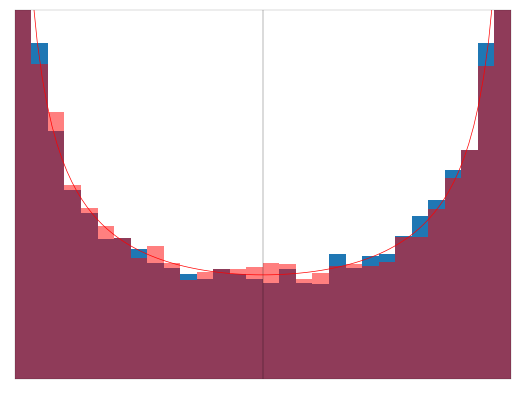

In [7]:
plot_hist(1.99, 0.0)

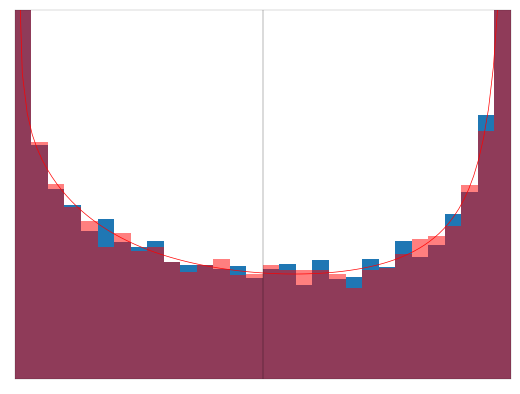

In [8]:
plot_hist(1.25, 0.5)

## Approximation

Now let's try to make the cdf easier to approximate by transforming both the x and y axes while preserving the asymptotic power law behavior of tails, namely that ([Nolan (2020)](https://edspace.american.edu/jpnolan/stable/) ss. 1.5 pp. 13 thm. 1.2) if $X\sim S(\alpha,\beta,\gamma,\delta;0)$ then
$$
P(X > x) \sim \gamma^\alpha c_\alpha (1+\beta) x^{-\alpha}
$$
where
$$
c_\alpha = \sin\left(\frac {\pi\alpha} 2\right)\Gamma(\alpha)/\pi
$$

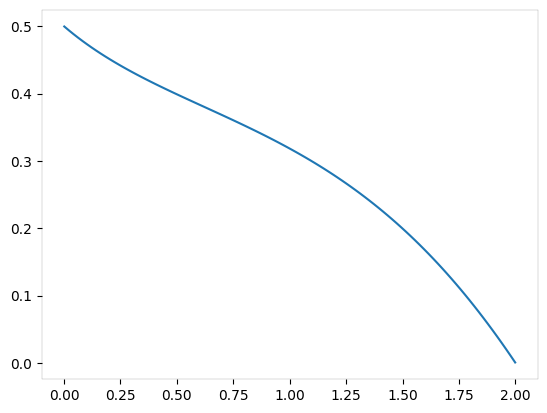

In [9]:
def plot_ca(eps=1e-3):
    a = np.linspace(0 + eps, 2 - eps, 100)
    ca = np.sin(np.pi * a / 2) * scipy.special.gamma(a) / np.pi
    plt.plot(a, ca)
plot_ca()

We want to approach the three asymptotes, in value (cdf) and in formal first derivative (pdf):
\begin{align*}
\text{As }\alpha\nearrow 2\!:&\quad
  u(x) \approx \operatorname{erf}(x/2)
\\
\text{As }x\nearrow\infty\!:&\quad
  u(x) \approx 1 - 2 c_\alpha(1+\beta)x(u)^{-\alpha}
\\
\text{As }x\searrow-\infty\!:&\quad
  u(x) \approx 2 c_\alpha(1-\beta)(-x(u))^{-\alpha} - 1
\end{align*}

### Symmetric case

In [10]:
def plot_symmetric(u_of_x, n=200):
    assert u_of_x.__name__ == "u_of_x"
    x = np.logspace(-2, 6, n)
    x = np.concatenate([-np.flip(x), x])
    fig, axes = plt.subplots(2, len(a_grid), figsize=(8,2.5), dpi=300)
    for i, a in enumerate(a_grid):
        u = u_of_x(a, x)
        ax = axes[0][i]
        ax.plot(np.tanh(x), levy_stable(a, 0).cdf(x) * 2 - 1, "k--", lw=1)
        ax.plot(np.tanh(x), u, "r-", markersize=1, lw=1)
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_xlabel(fr"$\alpha$ = {a:0.2f}")
        ax = axes[1][i]
        ax.plot(x, np.arctanh(levy_stable(a, 0).cdf(x) * 2 - 1), "k--", lw=1)
        ax.plot(x, np.arctanh(u), "r-", markersize=1, lw=1)
        ax.set_xscale("symlog")
        ax.set_yscale("symlog")
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_xlabel(fr"$\alpha$ = {a:0.2f}")
    plt.subplots_adjust(hspace=0, wspace=0)

/var/folders/b1/wvrl7j3566v_xfhch9qf76d80000gn/T/ipykernel_12973/1311381081.py:17: RuntimeWarning: invalid value encountered in arctanh
  ax.plot(x, np.arctanh(levy_stable(a, 0).cdf(x) * 2 - 1), "k--", lw=1)
/var/folders/b1/wvrl7j3566v_xfhch9qf76d80000gn/T/ipykernel_12973/1311381081.py:17: RuntimeWarning: divide by zero encountered in arctanh
  ax.plot(x, np.arctanh(levy_stable(a, 0).cdf(x) * 2 - 1), "k--", lw=1)
/var/folders/b1/wvrl7j3566v_xfhch9qf76d80000gn/T/ipykernel_12973/1311381081.py:18: RuntimeWarning: divide by zero encountered in arctanh
  ax.plot(x, np.arctanh(u), "r-", markersize=1, lw=1)


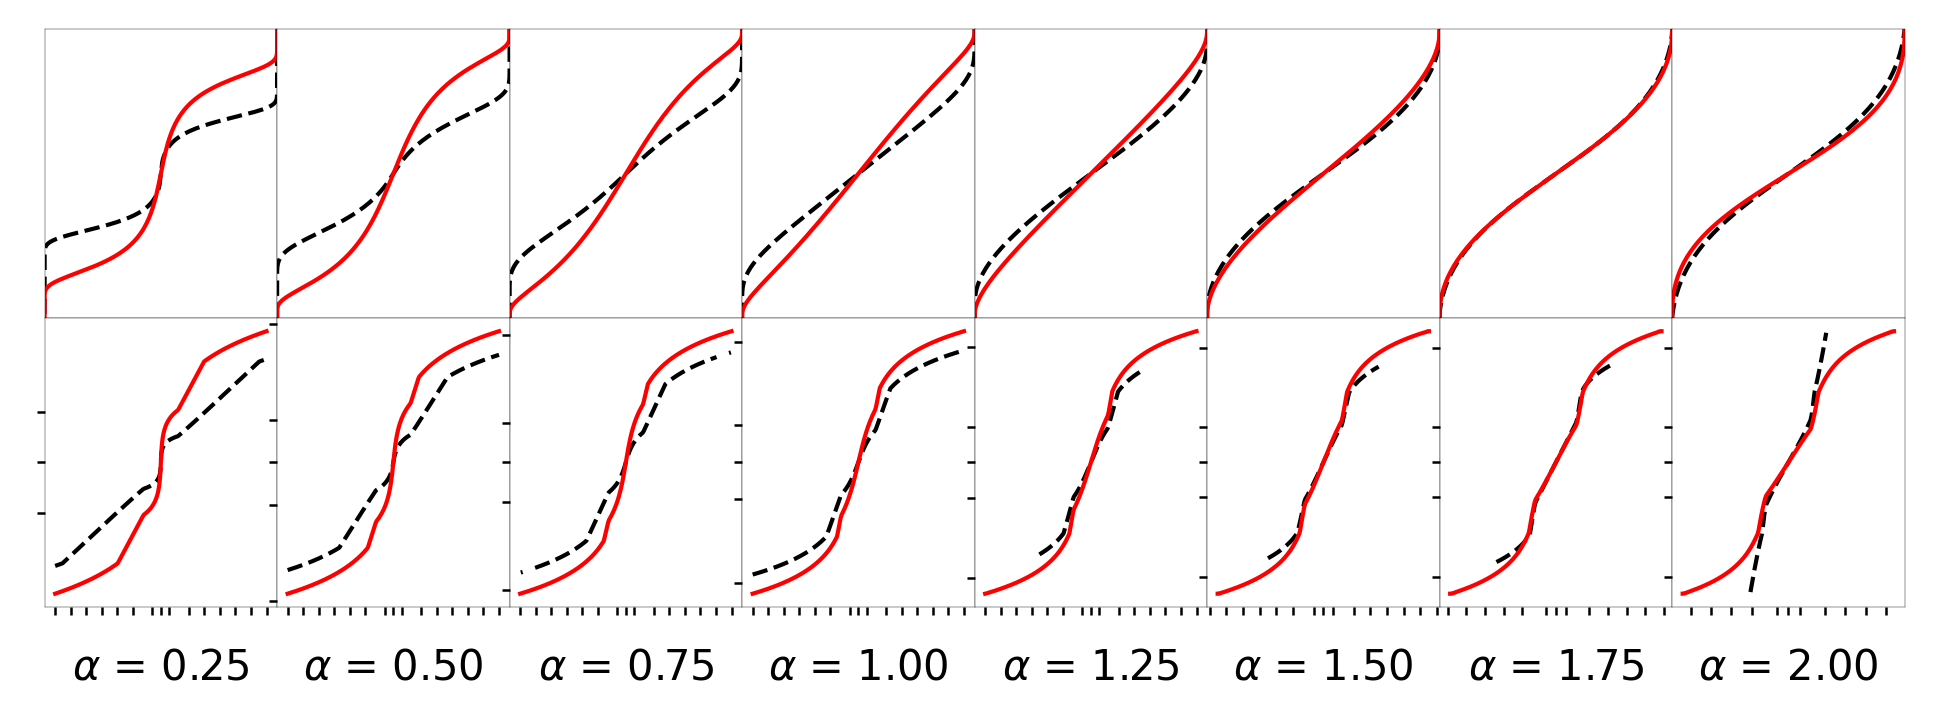

In [11]:
@plot_symmetric
def u_of_x(a, x):
    u = np.tanh(a * np.arcsinh(x / a**2))
    return u

/var/folders/b1/wvrl7j3566v_xfhch9qf76d80000gn/T/ipykernel_12973/1311381081.py:17: RuntimeWarning: invalid value encountered in arctanh
  ax.plot(x, np.arctanh(levy_stable(a, 0).cdf(x) * 2 - 1), "k--", lw=1)
/var/folders/b1/wvrl7j3566v_xfhch9qf76d80000gn/T/ipykernel_12973/1311381081.py:17: RuntimeWarning: divide by zero encountered in arctanh
  ax.plot(x, np.arctanh(levy_stable(a, 0).cdf(x) * 2 - 1), "k--", lw=1)
/var/folders/b1/wvrl7j3566v_xfhch9qf76d80000gn/T/ipykernel_12973/1311381081.py:18: RuntimeWarning: divide by zero encountered in arctanh
  ax.plot(x, np.arctanh(u), "r-", markersize=1, lw=1)


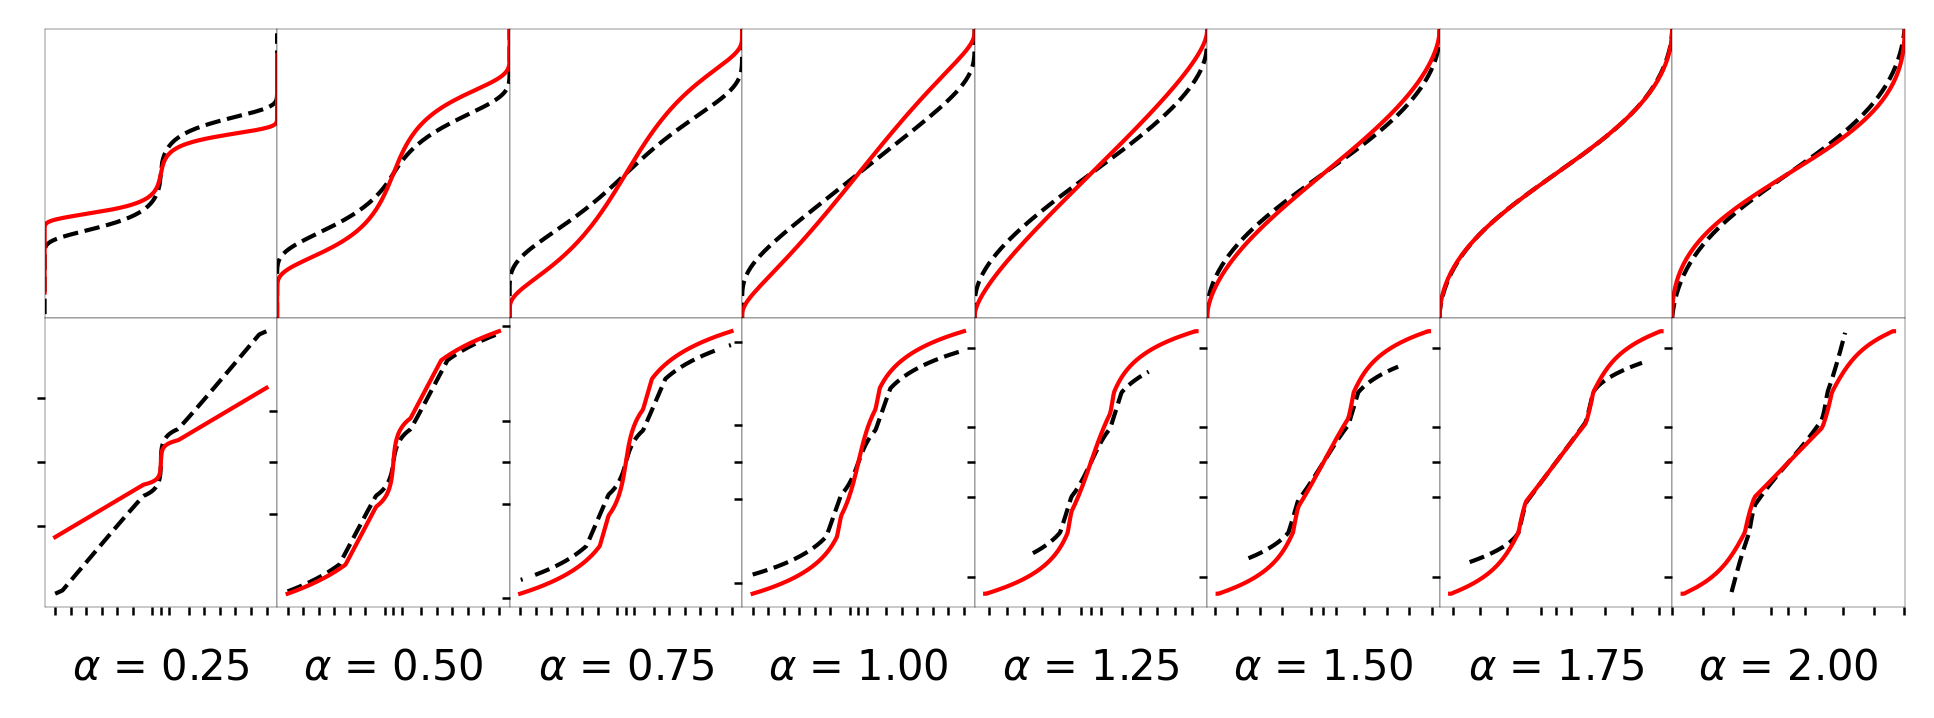

In [12]:
@plot_symmetric
def u_of_x(a, x):
    u = np.tanh(a**2 * np.arcsinh(x / a**3))
    return u

### Asymmetric case

In [13]:
def plot_transformed_cdf(u_of_x, n=100, eps=1e-3):
    assert u_of_x.__name__ == "u_of_x"
    x = np.arctanh(np.linspace(eps - 1, 1 - eps, n))
    fig, axes = plt.subplots(
        len(b_grid), len(a_grid), sharex=True, sharey=True,
        figsize=(0.5 + len(a_grid), 0.5 + len(b_grid)), dpi=300)
    for i, b in enumerate(b_grid):
        for j, a in enumerate(a_grid):
            u = u_of_x(x, a, b)
            z = S0_to_S1(a, b, x)
            v = levy_stable(a, b).cdf(z)
            ax = axes[i][j]
            ax.plot(u, v, "r-", lw=0.5)
            ax.plot([-1,1], [0,1], 'k--', lw=0.5, zorder=-1)
            ax.axvline(0, lw=0.2, color="k")
            ax.set_xlim(-1, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks(())
            ax.set_yticks(())
            if i == len(b_grid) - 1:
                ax.set_xlabel(f"α = {a:0.3g}")
            if j == 0:
                ax.set_ylabel(f"β = {b:0.3g}")
    plt.subplots_adjust(hspace=0, wspace=0)

Start with the Normal cdf, $\alpha=2$.

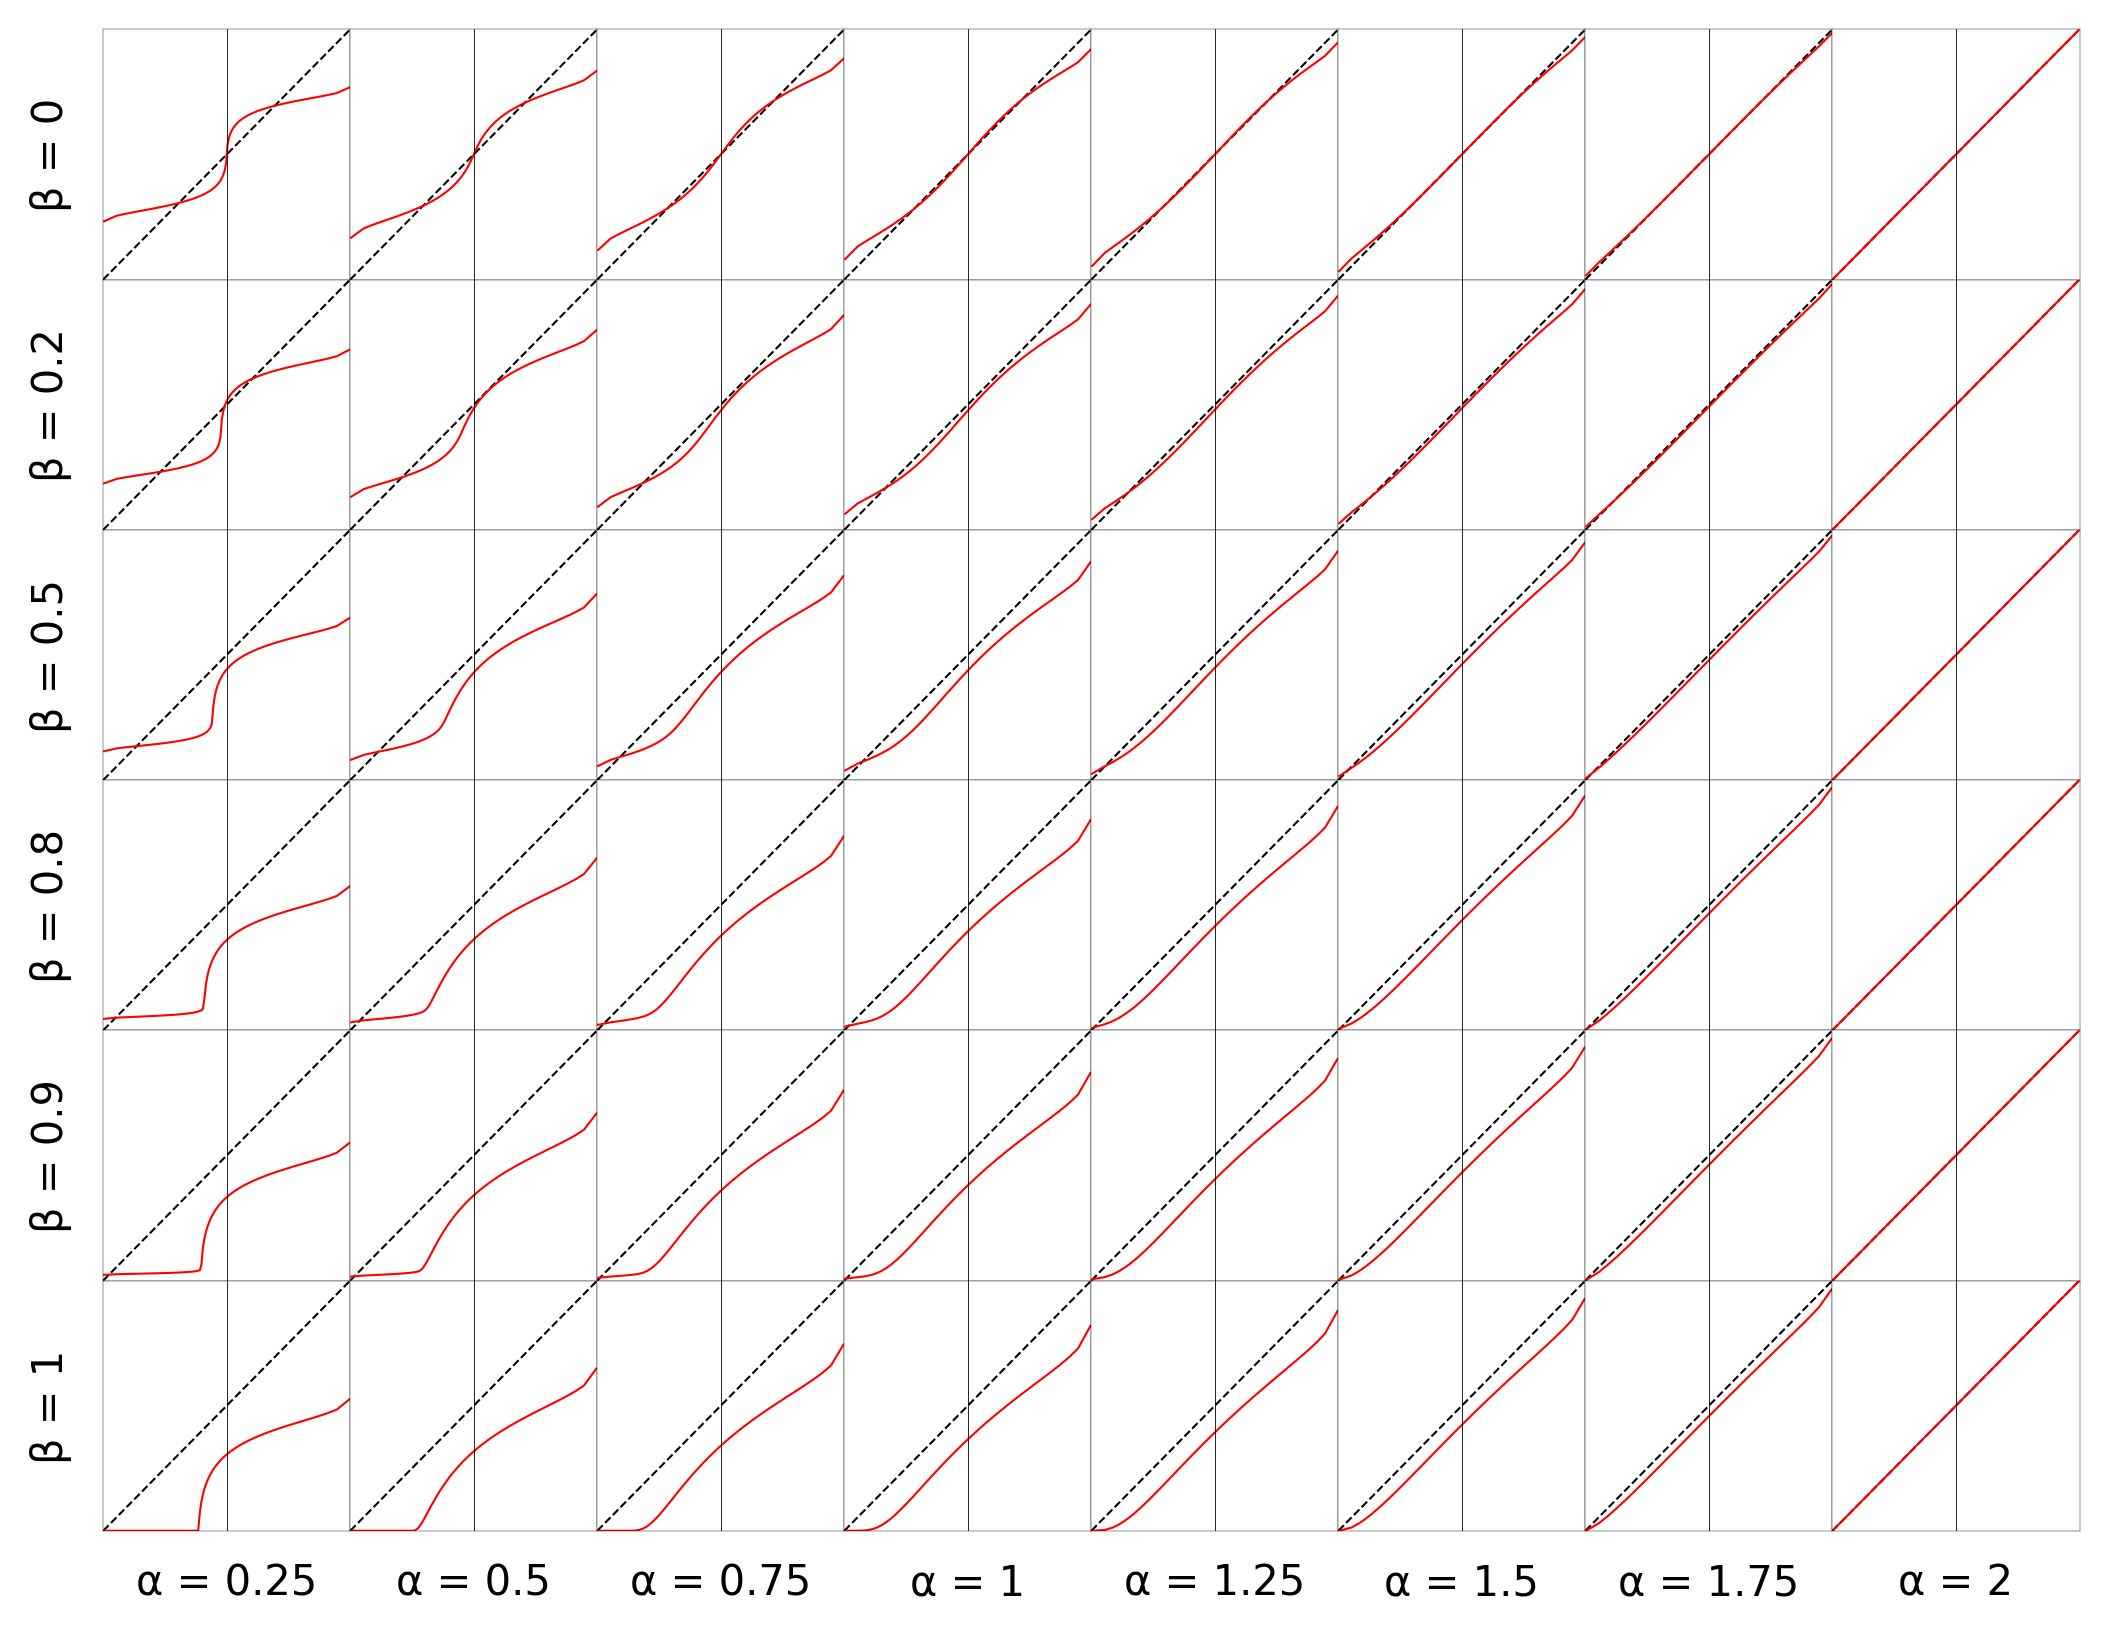

In [14]:
@plot_transformed_cdf
def u_of_x(x, a, b):
    u = scipy.special.erf(x / 2)
    return u

And the two asymptotes, piecewise.

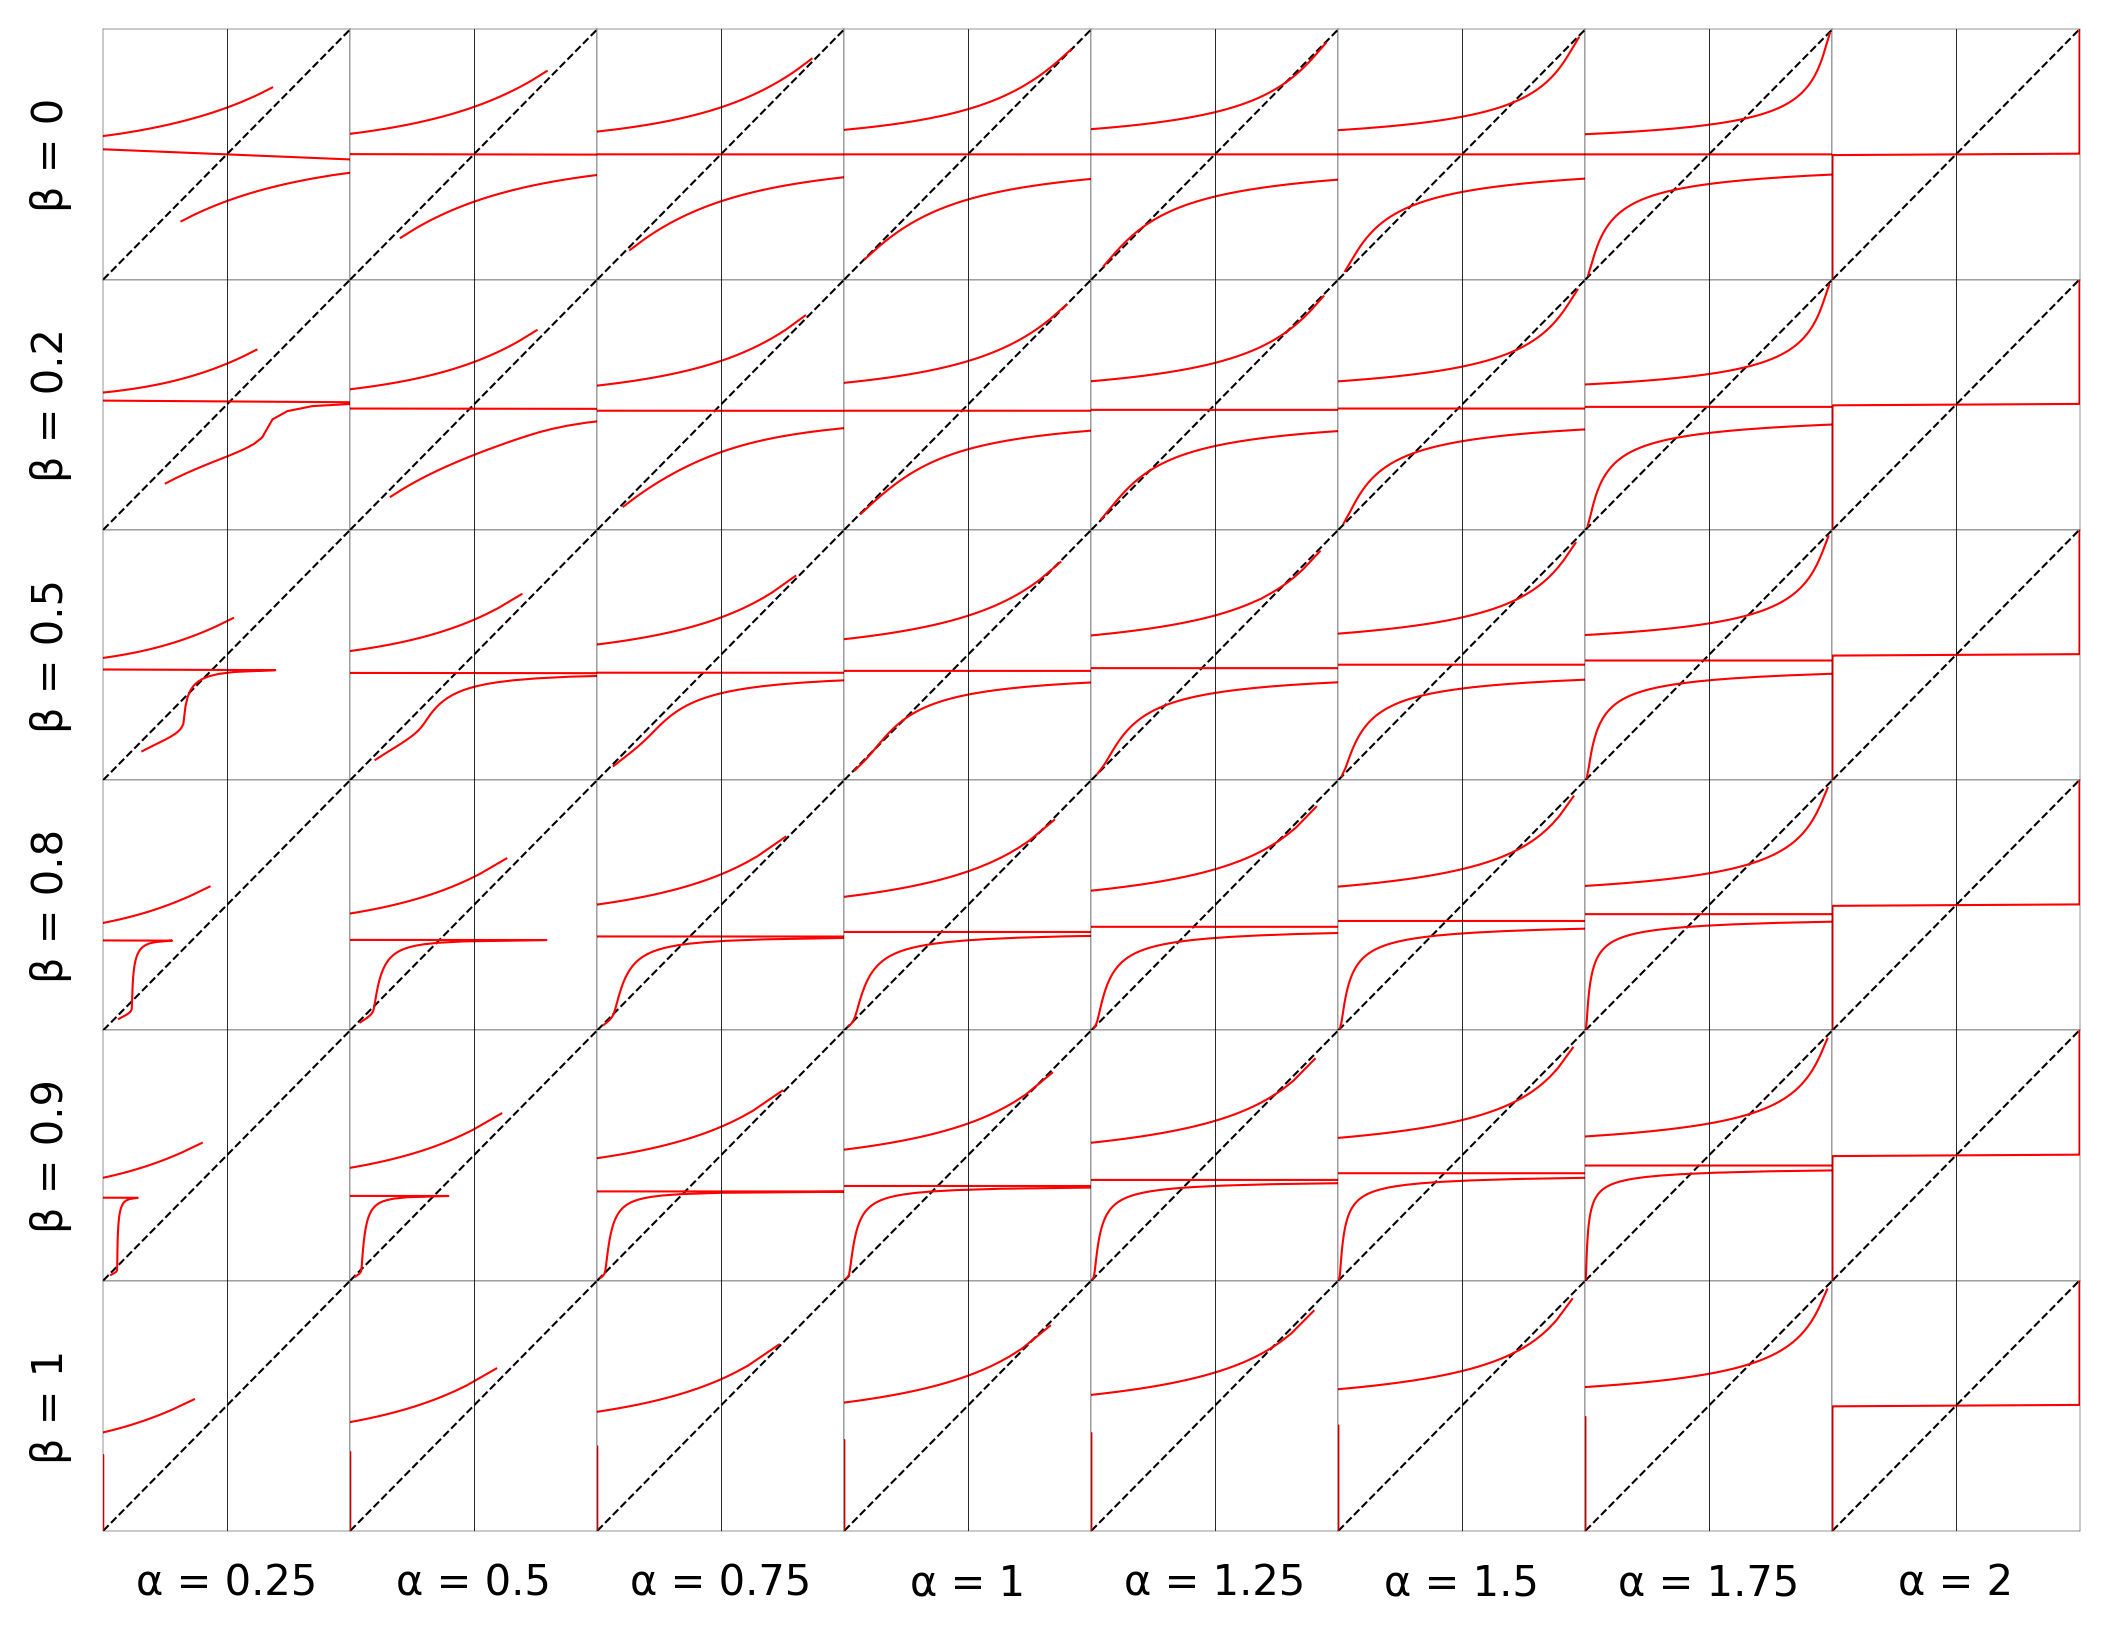

In [15]:
@plot_transformed_cdf
def u_of_x(x, a, b):
    ca = np.sin(np.pi * a / 2) * scipy.special.gamma(a) / np.pi
    s = np.sign(x)
    u = s * (1 - 2 * ca * (1 + b * s) / np.abs(x)**a)
    return u

Consider a naively interpolated coordinate system with $u\in(-1,1)$
$$
u(x) = \frac
{x \left(1 - 2c_\alpha(1+\beta s(x))\right)}
{(1+x^2)^{\frac {1+\alpha} 2}}
$$
where $s(-):\mathbb R\to(-1,1)$ is a sigmoid function such as $tanh(-)$.

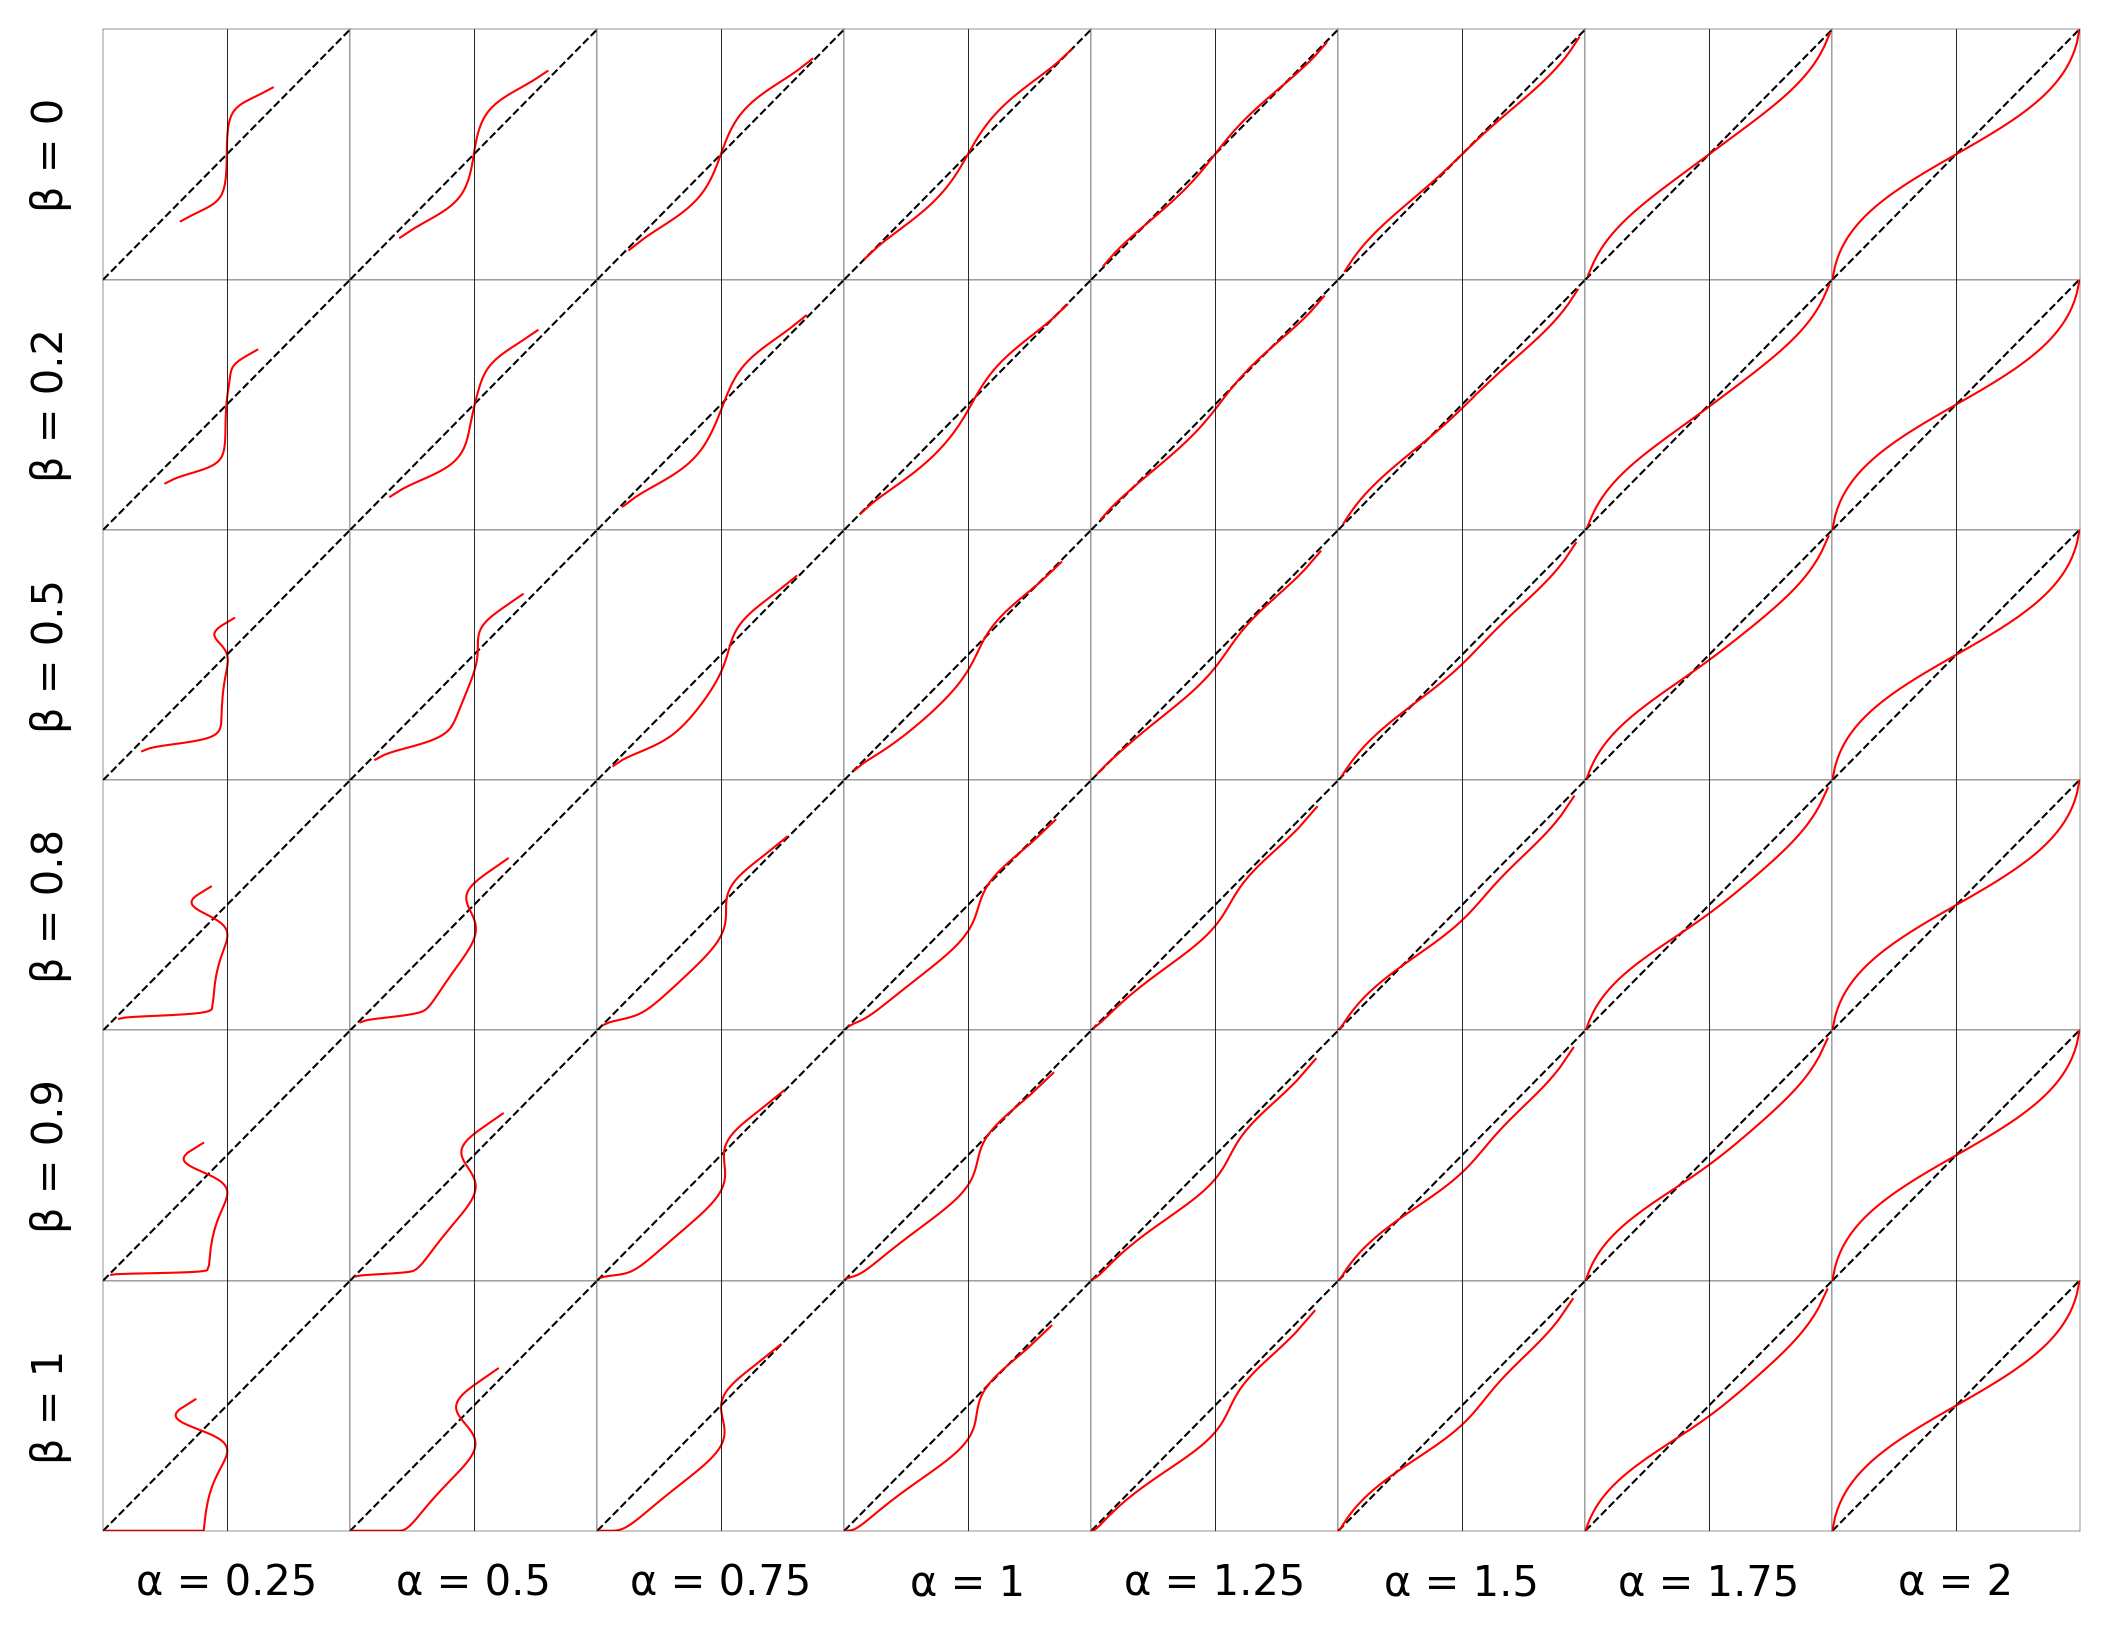

In [16]:
@plot_transformed_cdf
def u_of_x(x, a, b):
    ca = np.sin(np.pi * a / 2) * scipy.special.gamma(a) / np.pi
    s = np.tanh(x)
    u = s * (1 - 2 * ca * (1 + b * s) / (1 + x**2)**(a / 2))
    return u